<a href="https://colab.research.google.com/github/Samjacob007/image-segmentation/blob/main/Image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from pycocotools.coco import COCO
import skimage.io as io
from tensorflow.keras.utils import to_categorical
import matplotlib.patches as mpatches
from collections import defaultdict

%matplotlib inline

In [2]:
# Mount Drive & unzip
from google.colab import drive
drive.mount("/content/drive")
!unzip -o "/content/drive/MyDrive/RM_Segmentation_Assignment_dataset.zip" -d "/content/drive/MyDrive/coco2017/"

Mounted at /content/drive
Archive:  /content/drive/MyDrive/RM_Segmentation_Assignment_dataset.zip
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001751.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001380.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001643.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001583.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001685.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001482.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001494.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001551.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001654.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001594.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001411.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001459.jpg  
  inflating: /content/drive/MyDrive/co

In [16]:
 #Paths and constants
train_data_path = "/content/drive/MyDrive/coco2017/train-300"
train_annotation_file = f"{train_data_path}/labels.json"
IMAGE_SIZE = (256, 256)

# Load COCO
coco = COCO(train_annotation_file)

# Define target classes
target_classes = ["cake", "car", "dog", "person"]
target_classes_IDs = coco.getCatIds(catNms=target_classes)
NUM_CLASSES = len(target_classes) + 1  # +1 for background

# Load categories
categories = coco.loadCats(coco.getCatIds())

# Helper function

def get_category_name(class_ID, categories):
    for cat in categories:
        if cat["id"] == class_ID:
            return cat["name"]
    return "None"

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [18]:
# Check how many images are available per class
print("Available per class:")
for cls in target_classes:
    print(f"{cls}: {len(class_to_images[cls])}")

# Use the minimum available count (or a safe number like 10)
val_ids = set(
    random.sample(list(class_to_images["cake"]), min(10, len(class_to_images["cake"]))) +
    random.sample(list(class_to_images["car"]), min(10, len(class_to_images["car"]))) +
    random.sample(list(class_to_images["dog"]), min(10, len(class_to_images["dog"]))) +
    random.sample(list(class_to_images["person"]), min(10, len(class_to_images["person"])))
)

# Remaining for training
all_ids = set(class_to_images["cake"] | class_to_images["car"] | class_to_images["dog"] | class_to_images["person"])
train_ids = list(all_ids - val_ids)

val_imgs = coco.loadImgs(list(val_ids))
train_imgs = coco.loadImgs(train_ids)

print(f"✅ Final Split ➤ Train: {len(train_imgs)}, Val: {len(val_imgs)}")

Available per class:
cake: 1
car: 283
dog: 10
person: 272
✅ Final Split ➤ Train: 272, Val: 28


In [19]:
# ✅ Process function to load images + masks
def process_image_list(image_list, coco, target_classes, target_classes_IDs, categories, image_size=(256, 256)):
    images, masks = [], []
    for img_info in tqdm(image_list):
        img_path = os.path.join(train_data_path, 'data', img_info['file_name'])
        image = cv2.imread(img_path)
        if image is None:
            continue
        image = cv2.resize(image, image_size) / 255.0
        images.append(image)

        ann_ids = coco.getAnnIds(imgIds=img_info["id"], catIds=target_classes_IDs, iscrowd=None)
        anns = coco.loadAnns(ann_ids)

        mask = np.zeros((img_info["height"], img_info["width"]), dtype=np.uint8)
        for ann in anns:
            name = get_category_name(ann["category_id"], categories)
            if name in target_classes:
                idx = target_classes.index(name) + 1
                mask = np.maximum(coco.annToMask(ann) * idx, mask)

        mask = cv2.resize(mask, image_size, interpolation=cv2.INTER_NEAREST)
        masks.append(mask)

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.uint8)

In [20]:
# Load and preprocess data
X_train, y_train_raw = process_image_list(train_imgs, coco, target_classes, target_classes_IDs, categories)
X_val, y_val_raw = process_image_list(val_imgs, coco, target_classes, target_classes_IDs, categories)

# One-hot encode masks
y_train = to_categorical(y_train_raw, num_classes=NUM_CLASSES)
y_val = to_categorical(y_val_raw, num_classes=NUM_CLASSES)

#  Check class balance in validation
val_class_counts = np.sum(np.argmax(y_val, axis=-1).reshape(-1, 1) == np.arange(NUM_CLASSES), axis=0)
print("Pixel counts per class in y_val:", val_class_counts)
print("Classes:", ['background'] + target_classes)


100%|██████████| 28/28 [00:00<00:00, 34.72it/s]


Pixel counts per class in y_val: [1566332    5096  125577   36458  101545]
Classes: ['background', 'cake', 'car', 'dog', 'person']


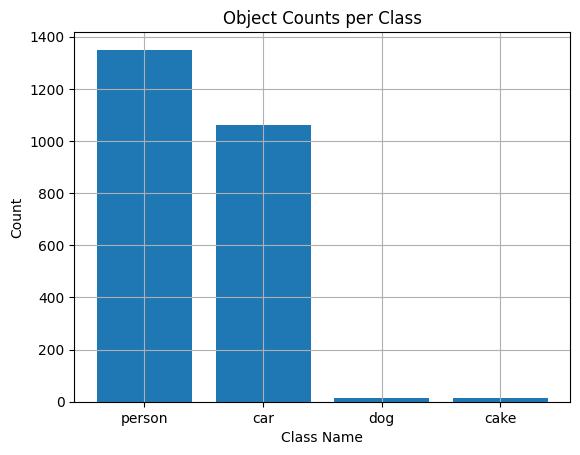

In [22]:
from collections import Counter

class_counts = Counter()
for ann in coco.dataset['annotations']:
    name = get_category_name(ann["category_id"], categories)
    if name in target_classes:
        class_counts[name] += 1

plt.bar(class_counts.keys(), class_counts.values())
plt.title("Object Counts per Class")
plt.ylabel("Count")
plt.xlabel("Class Name")
plt.grid(True)
plt.show()

<ipython-input-23-3811090210>:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([areas[c] for c in target_classes], labels=target_classes)


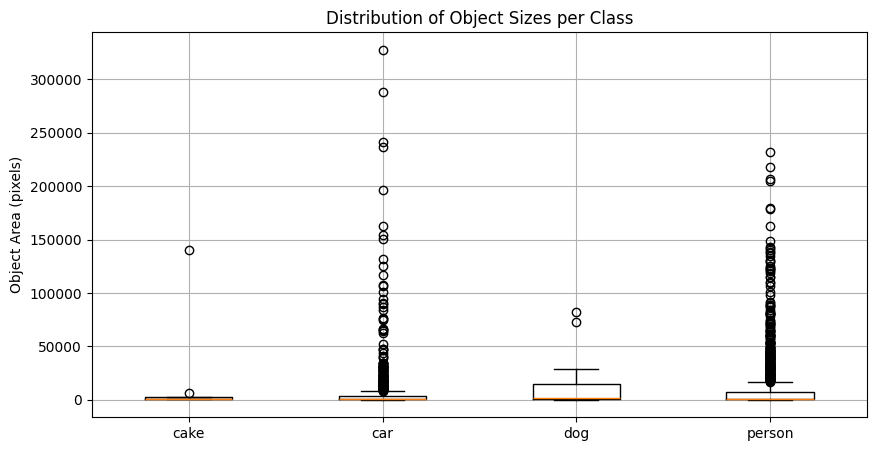

In [23]:
areas = {cls: [] for cls in target_classes}
for ann in coco.dataset['annotations']:
    name = get_category_name(ann["category_id"], categories)
    if name in target_classes:
        areas[name].append(ann['area'])

plt.figure(figsize=(10, 5))
plt.boxplot([areas[c] for c in target_classes], labels=target_classes)
plt.ylabel("Object Area (pixels)")
plt.title("Distribution of Object Sizes per Class")
plt.grid(True)
plt.show()

<ipython-input-28-4280693027>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', NUM_CLASSES)


✅ Saved to sample_visualization_1.png


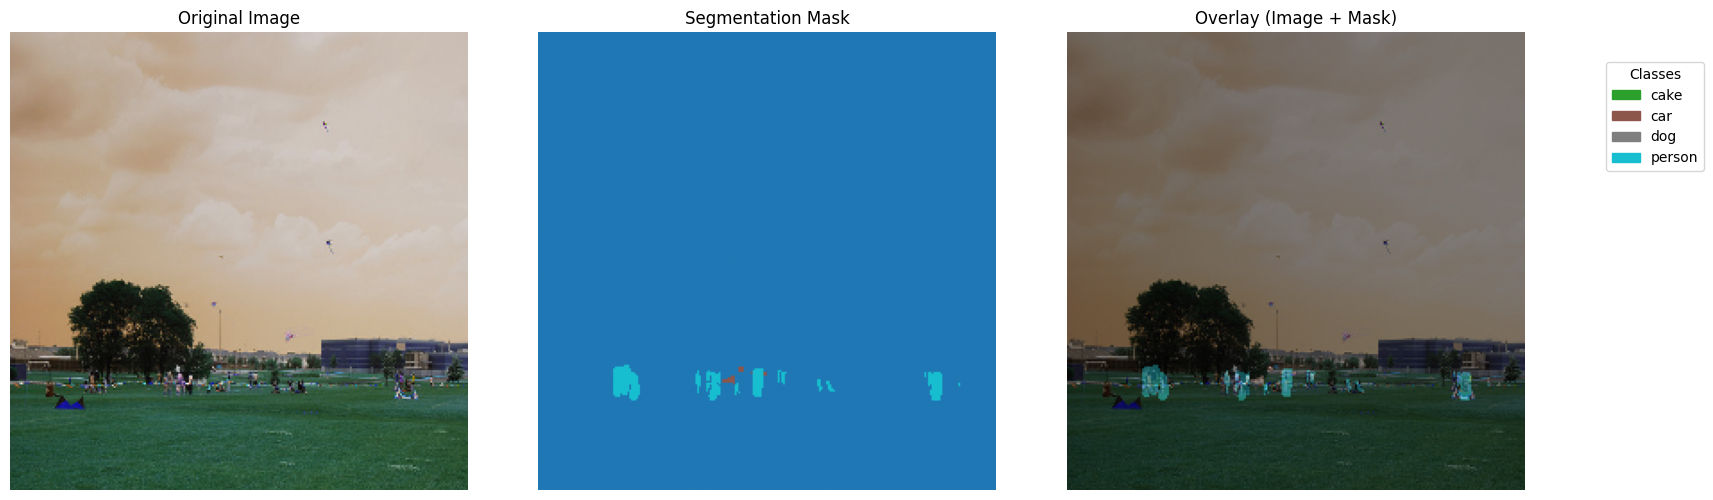

✅ Saved to sample_visualization_2.png


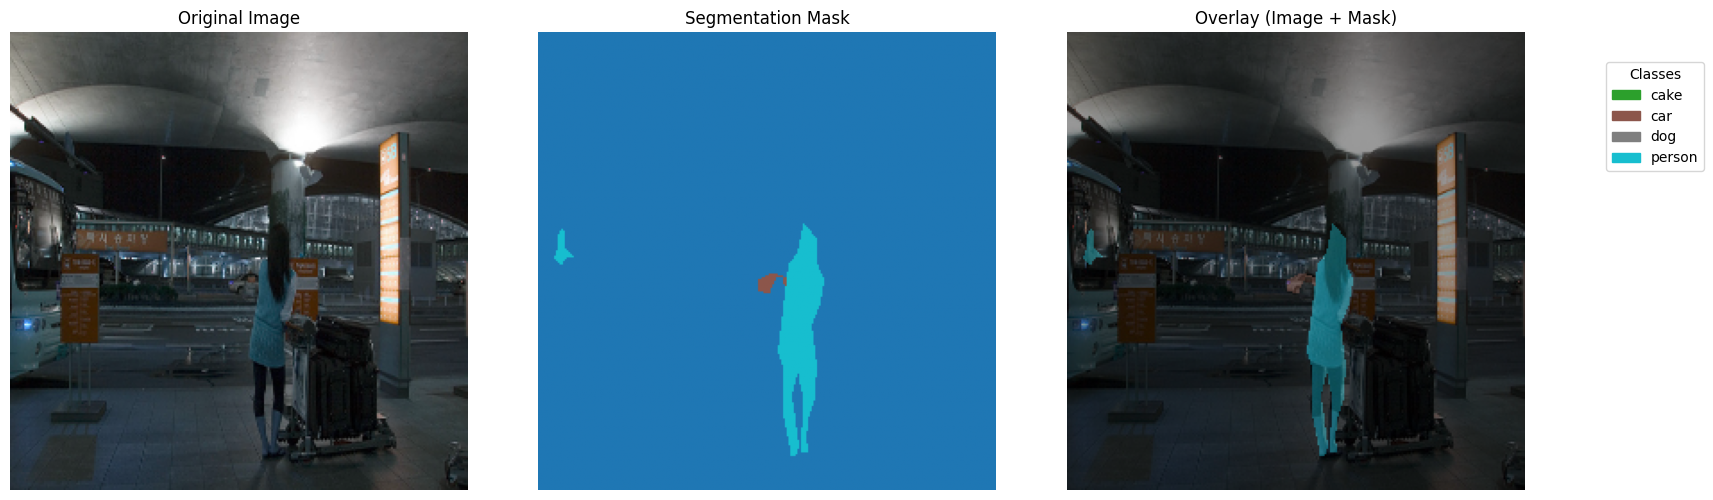

✅ Saved to sample_visualization_3.png


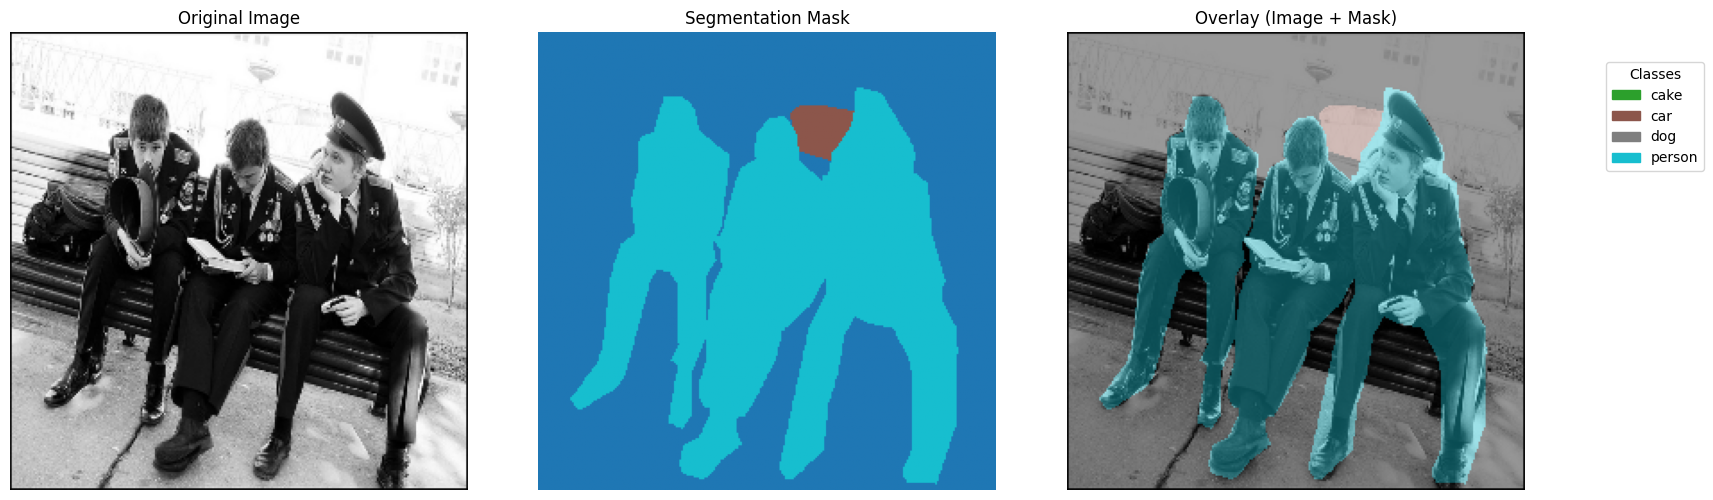

In [28]:
def visualize_sample_with_legend(image, mask, idx=None, save=False, save_path=None):
    # Convert one-hot to categorical if needed
    if len(mask.shape) == 3 and mask.shape[-1] == NUM_CLASSES:
        mask = np.argmax(mask, axis=-1)

    colored_mask = np.zeros_like(image)
    cmap = plt.cm.get_cmap('tab10', NUM_CLASSES)

    for cls in range(1, NUM_CLASSES):  # skip background
        class_color = cmap(cls / NUM_CLASSES)[:3]
        colored_mask[mask == cls] = class_color

    overlay = 0.6 * image + 0.4 * colored_mask

    legend_elements = [
        mpatches.Patch(color=cmap(i / NUM_CLASSES), label=target_classes[i - 1])
        for i in range(1, NUM_CLASSES)
    ]

    fig, axs = plt.subplots(1, 3, figsize=(16, 5))

    axs[0].imshow(image)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(mask, cmap='tab10', vmin=0, vmax=NUM_CLASSES - 1)
    axs[1].set_title("Segmentation Mask")
    axs[1].axis('off')

    axs[2].imshow(overlay)
    axs[2].set_title("Overlay (Image + Mask)")
    axs[2].axis('off')

    fig.legend(handles=legend_elements, bbox_to_anchor=(1.02, 0.9), loc='upper left', title="Classes")
    plt.tight_layout()

    if save and save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved to {save_path}")

    plt.show()
# Visualize 3 samples from the balanced training data
for i in range(3):
    visualize_sample_with_legend(
        X_train[i], y_train_raw[i],
        save=True,
        save_path=f"sample_visualization_{i+1}.png"
    )
